# Brain Tumor EDA

**import necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform, GlorotUniform
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import random

from PIL import Image
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import datasets

In [ ]:
# Load the  brain_tumor_train_df and brain_tumor_test_df
train_df = pd.read_csv('brain_tumor_train.csv')
test_df = pd.read_csv('brain_tumor_test.csv')


**Split train_df to train and validation dataframes

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df,val_df = train_test_split(train_df,test_size=0.2,random_state=42,stratify=train_df['label'])

#  Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the data generators for train, validation, and test
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



    # Create train and validation generators
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=(240, 240),
        batch_size=32,
        class_mode='categorical',
        shuffle = True,
         color_mode='rgb',

    )

val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=(240, 240),
        batch_size=32,
        class_mode='categorical',
         color_mode='rgb',
    )

    # Create a test generator (using the test dataframe, assuming you have one)
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=(240, 240),
        batch_size=32,
        class_mode='categorical',
        shuffle = False,
         color_mode='rgb',
    )

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 5712 validated image filenames belonging to 4 classes.


In [ ]:
print(len(train_generator))
print(len(val_generator))

143
36


In [ ]:
x, y = next(iter(train_generator))
print(x.shape, y.shape)

(32, 240, 240, 3) (32, 4)


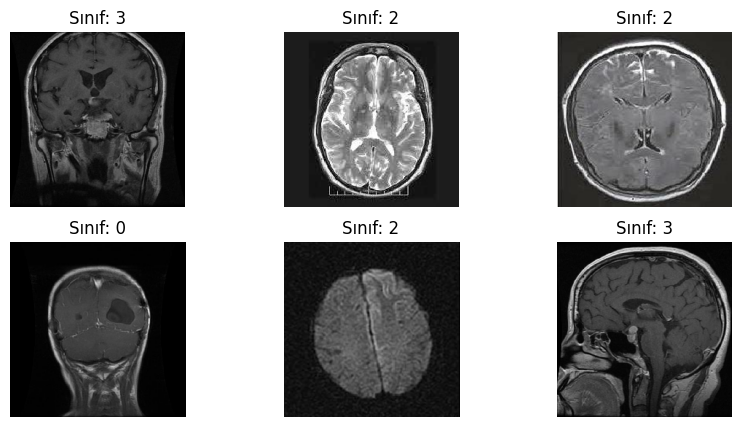

In [ ]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Sınıf: {np.argmax(y_batch[i])}")
    plt.axis("off")
plt.show()

# VGG16 MODEL

"VGG16 is a deep convolutional neural network architecture known for its simplicity and effectiveness in image classification tasks. It consists of 16 layers (13 convolutional layers and 3 fully connected layers) and uses small 3x3 filters with a stride of 1 and max-pooling layers with a 2x2 window. The network is trained on large datasets like ImageNet and is effective in capturing hierarchical features in images

In [ ]:
from tensorflow.keras.applications import VGG16
vgg16_base = VGG16(weights="imagenet" , include_top=False , input_shape=(240,240,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in vgg16_base.layers:
    layer.trainable =False

x = Flatten()(vgg16_base.output)
x = Dense(64 , activation="relu" , kernel_initializer=HeUniform())(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128 , activation="relu" , kernel_initializer=HeUniform())(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256 , activation="relu" , kernel_initializer=HeUniform())(x)

x = Dense(4, activation="softmax")(x)

model = Model(inputs= vgg16_base.input , outputs=x)


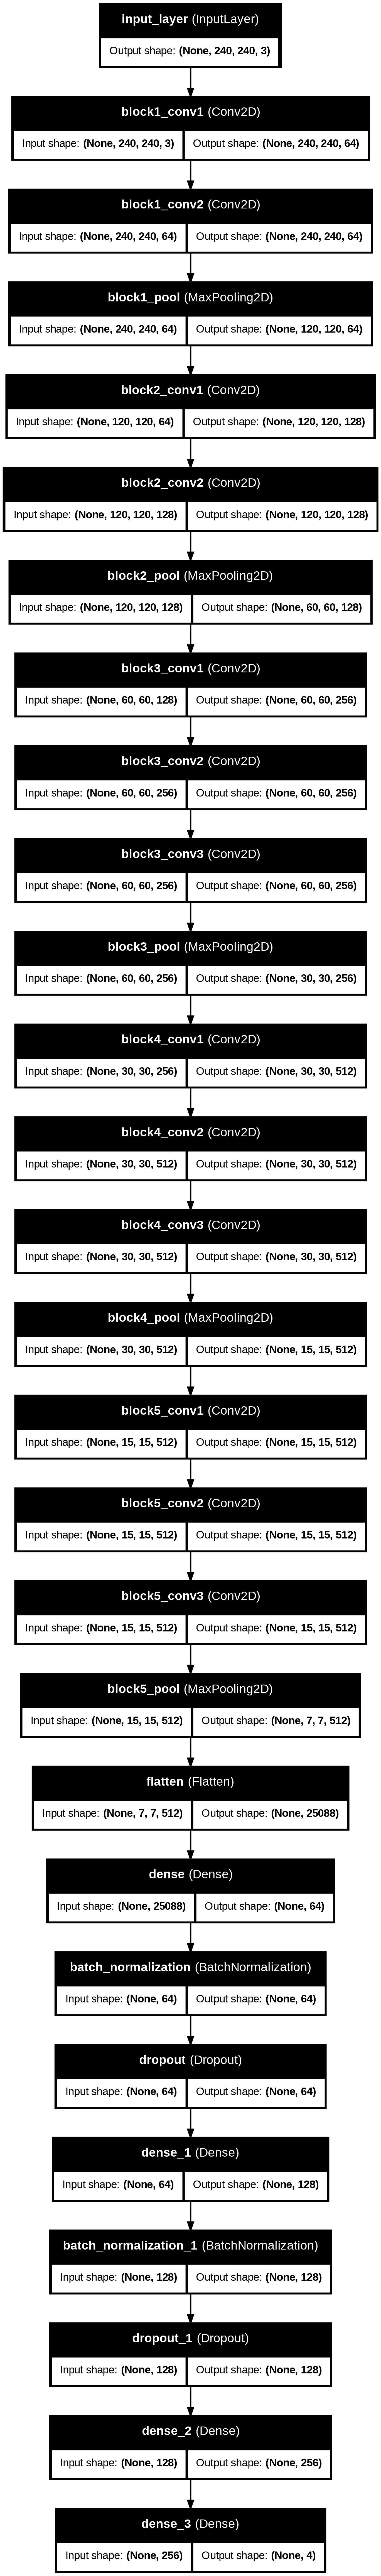

In [ ]:
#plot hierarical for this model

from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights outside the model.fit call
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes)

class_weights_dict = dict(enumerate(class_weights))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001) , loss = "categorical_crossentropy" , metrics=["accuracy"])

In [ ]:
model.fit(train_generator,
          validation_data=val_generator,
          epochs=15,
          class_weight = class_weights_dict,
          callbacks =[early_stopping, reduce_lr,checkpoint]
          )

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.7110 - loss: 0.7728
Epoch 1: val_accuracy improved from -inf to 0.87752, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 366ms/step - accuracy: 0.7117 - loss: 0.7712 - val_accuracy: 0.8775 - val_loss: 0.3374 - learning_rate: 0.0010
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8837 - loss: 0.3239
Epoch 2: val_accuracy improved from 0.87752 to 0.90639, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 187ms/step - accuracy: 0.8838 - loss: 0.3238 - val_accuracy: 0.9064 - val_loss: 0.2726 - learning_rate: 0.0010
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9237 - loss: 0.2022
Epoch 3: val_accuracy improved from 0.90639 to 0.90901, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - accuracy: 0.9237 - loss: 0.2023 - val_accuracy: 0.9090 - val_loss: 0.2473 - learning_rate: 0.0010
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 

179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 209ms/step - accuracy: 0.9957 - loss: 0.0168
Test Loss: 0.0335
Test Accuracy: 0.9919
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 163ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1321
           1       0.98      0.99      0.98      1339
           2       1.00      1.00      1.00      1595
           3       0.99      1.00      0.99      1457

    accuracy                           0.99      5712
   macro avg       0.99      0.99      0.99      5712
weighted avg       0.99      0.99      0.99      5712



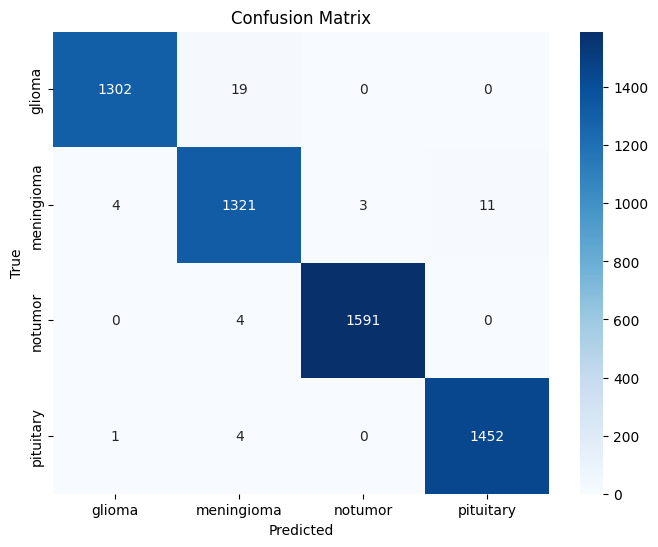

In [ ]:
#evaluate the model

import matplotlib.pyplot as plt
import numpy as np
# Load the best saved model
model = load_model('best_model.keras')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes


# Generate classification report
print(classification_report(y_true, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Here I get the desired accuracy from the the first attemp

**save the model**

In [ ]:
model.save("brain_tumor.h5")

In [2]:
import tensorflow as tf
model = model = tf.keras.models.load_model("/content/brain_tumor.h5")

In [3]:
class_names =["glioma" ,"meningioma","notumor","pituitary"]


# Function for predicting and geaerating areport

    * Predict chest X-ray class and generate a formal medical-style report.
     Parameters:
    - model: Trained Keras model
    - image_path: Full path to the image
    - class_names: List of class labels
    - patient_id: Optional patient ID

    Returns:
    - None (shows image and prints a medical-style report)
  

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def predict_and_generate_medical_report(model, image_path):


    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: couldn't read image:", image_path)
        return

    #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img_resized = cv2.resize(img_rgb, (224, 224))
    img =cv2.resize(img,(240,240))
    img_normalized = img / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)

    # Model prediction
    prediction = model.predict(img_input)
    predicted_index = np.argmax(prediction)
    confidence = prediction[0][predicted_index] * 100
    predicted_label = class_names[predicted_index]


    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f" Predicted: {predicted_label}", fontsize=11, color='darkgreen')
    plt.show()

    # Generate the medical report
    print("=" * 50)
    print("              Brain Tumor-MRI Radiology Report")
    print("=" * 50)
   # print(f"Patient ID        : {patient_id}")
    print(f"Image Path        : {image_path}")

    print(f"AI Prediction     : {predicted_label}")
    print(f"Confidence Score  : {confidence:.2f}%")
    print("-" * 50)
    print("Radiologist Note:")
    if predicted_label == "glioma":
        print( "-Glioma- Tumor-The MRI scan demonstrates a mass lesion consistent with a glioma tumor. The lesion appears infiltrative with irregular borders and heterogeneous signal intensity. The tumor may involve both gray and white matter and shows mild mass effect. Edema is also noted surrounding the lesion.",
)
    elif predicted_label == "meningioma":
        print( " -Meningioma Tumor-MRI reveals a well-defined, extra-axial mass with broad dural attachment. The lesion demonstrates homogeneous enhancement post-contrast and shows a classic “dural tail” sign, which is characteristic of meningioma. There is mild mass effect, but no evidence of parenchymal invasion.",
)
    elif predicted_label == "notumor":
        print( " -No Tumor- MRI scan appears within normal limits. No evidence of space-occupying lesions, abnormal signal intensity, or midline shift. Ventricular system and sulci are preserved, and no signs of edema or hemorrhage are identified.")

    elif predicted_label == "pituitary":
        print(" -Pituitary Tumor- There is an enhancing lesion within the sella turcica, involving the pituitary gland. The mass mildly expands the sella and abuts the optic chiasm superiorly. The imaging features are consistent with a pituitary adenoma. No evidence of hemorrhage or invasion is noted")

    else:
        print("  - Unclear findings. Further clinical evaluation and additional imaging may be required.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


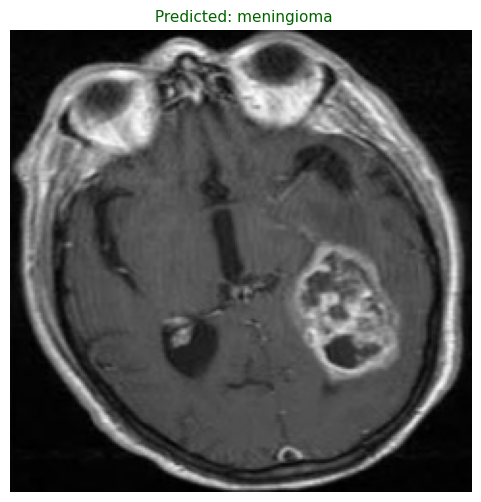

              Brain Tumor-MRI Radiology Report
Image Path        : /content/Te-meTr_0001.jpg
AI Prediction     : meningioma
Confidence Score  : 67.59%
--------------------------------------------------
Radiologist Note:
 -Meningioma Tumor-MRI reveals a well-defined, extra-axial mass with broad dural attachment. The lesion demonstrates homogeneous enhancement post-contrast and shows a classic “dural tail” sign, which is characteristic of meningioma. There is mild mass effect, but no evidence of parenchymal invasion.


In [14]:
image_path ="/content/Te-meTr_0001.jpg"
predict_and_generate_medical_report(model, image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


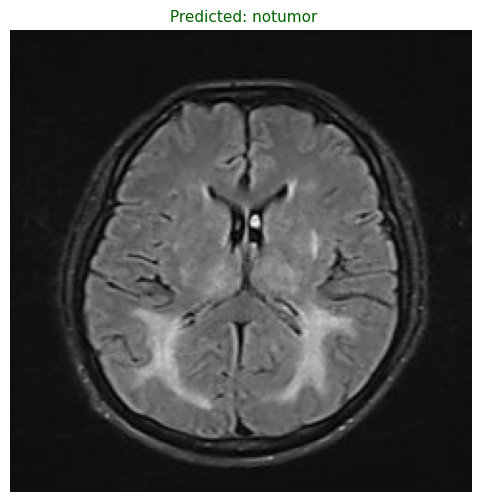

              Brain Tumor-MRI Radiology Report
Image Path        : /content/Te-noTr_0001.jpg
AI Prediction     : notumor
Confidence Score  : 100.00%
--------------------------------------------------
Radiologist Note:
 -No Tumor- MRI scan appears within normal limits. No evidence of space-occupying lesions, abnormal signal intensity, or midline shift. Ventricular system and sulci are preserved, and no signs of edema or hemorrhage are identified.


In [15]:
image_path ="/content/Te-noTr_0001.jpg"
predict_and_generate_medical_report(model, image_path)